In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
import tesswcs
from tesswcs import pointings
from tesswcs.utils import footprint


import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, Angle

import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.animation import FuncAnimation, PillowWriter
mpl.rcParams['figure.dpi'] = 150

In [2]:
ecliptic_plane = SkyCoord(np.arange(0, 360, 1), np.arange(0, 360, 1)*0, unit='deg', frame='geocentricmeanecliptic').transform_to('icrs')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


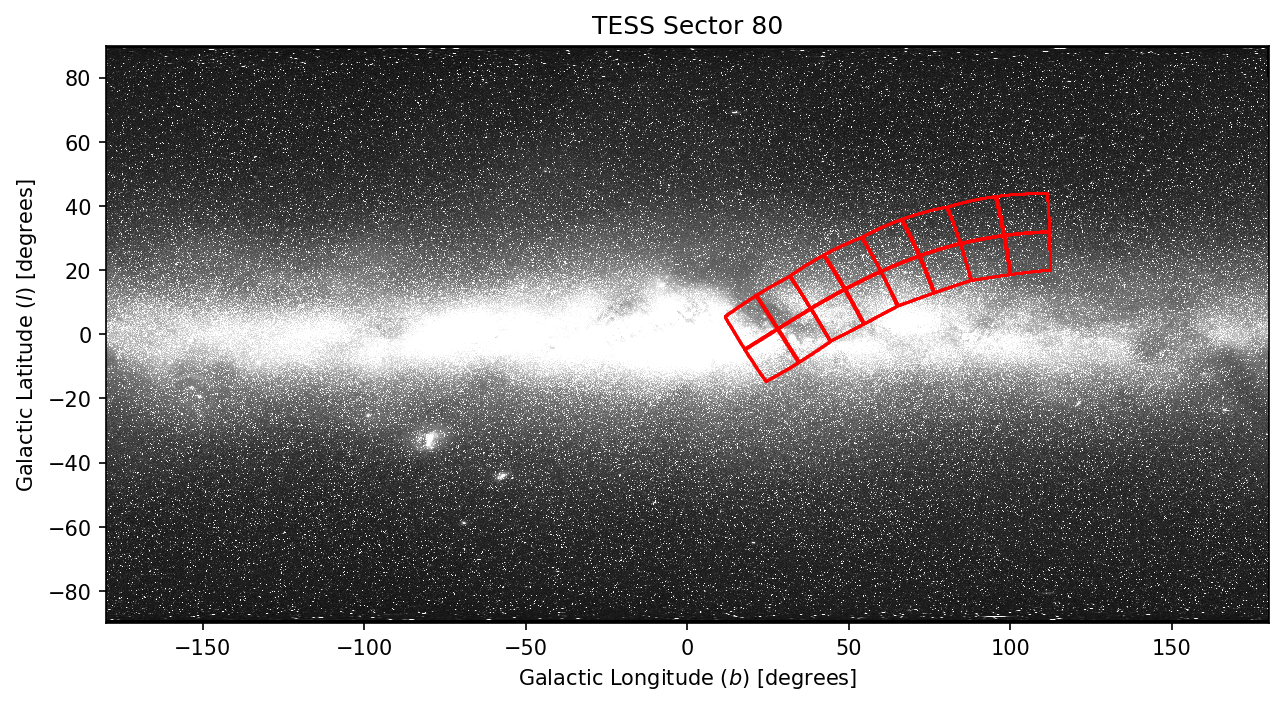

In [4]:
url = '/Users/vkostov/Desktop/backdrop.fits'#'http://galaxy.phy.cmich.edu/~axel/mwpan2/mwpan2_RGB_3600.fits'
hdu = fits.open(url, cache=True)[0]
wcs = WCS(hdu.header).dropaxis(-1)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
# add the image

R, C = np.meshgrid(np.arange(wcs.pixel_shape[1]), np.arange(wcs.pixel_shape[0]), indexing='ij')
c = wcs.pixel_to_world(C, R)
flux_data = hdu.data.sum(axis=0)
im = plt.pcolormesh(np.nan_to_num(c.l.wrap_at(180*u.deg).deg), np.nan_to_num(c.b.deg), flux_data, vmin=0, vmax=1000, cmap='Greys_r', zorder=-10, shading='nearest')
ax.set(xlabel='Galactic Longitude ($b$) [degrees]', ylabel='Galactic Latitude ($l$) [degrees]')

def get_points(sector = 1):
    pointing = np.asarray(pointings[pointings['Sector'] == sector][['RA', "Dec", "Roll"]])[0]
    x, y = [], []
    for camera in np.arange(1, 5):
        for ccd in np.arange(1, 5):
            wcs = tesswcs.WCS.predict(*pointing, camera=camera, ccd=ccd)
            c = wcs.pixel_to_world(*footprint(npoints=100).T).transform_to('galactic')
            x.append(c.l.wrap_at(180*u.deg).deg)
            y.append(c.b.deg)
    return np.hstack(x), np.hstack(y)

#scatter = ax.scatter(*get_points(sector=1), c='r', s=0.1)
# Initialize the scatter plot
scatter = ax.scatter([], [], c='r', s=0.1)

def update(sector):
    scatter.set_offsets(np.vstack(get_points(sector=sector)).T)
    ax.set_title(f'TESS Sector {sector}')
    plt.savefig(f'tess_galactic_sector_{sector:03d}.png')

ani = FuncAnimation(fig, update, frames=np.arange(80, 85), repeat=False)

# Save the animation as a GIF
writer = PillowWriter(fps=1)
ani.save("tess_sectors_galactic_coordinates.gif", writer=writer)

In [5]:
# Interpolate image to ICRS
c_back = wcs.pixel_to_world(C, R).transform_to('icrs')
# xi, yi = np.linspace(-180, 180, 3000), np.linspace(-90, 90, 1500)
xi, yi = np.linspace(-180, 180, 600), np.linspace(-90, 90, 300)
zi = np.asarray(griddata((np.nan_to_num(c_back.ra.wrap_at(180*u.deg).deg.flatten()),
                          np.nan_to_num(c_back.dec.deg.flatten())),
                          flux_data.flatten(),
                          (xi[None,:], yi[:,None])
                         ))
c_low = SkyCoord(*np.meshgrid(xi, yi), unit='deg', frame='icrs')

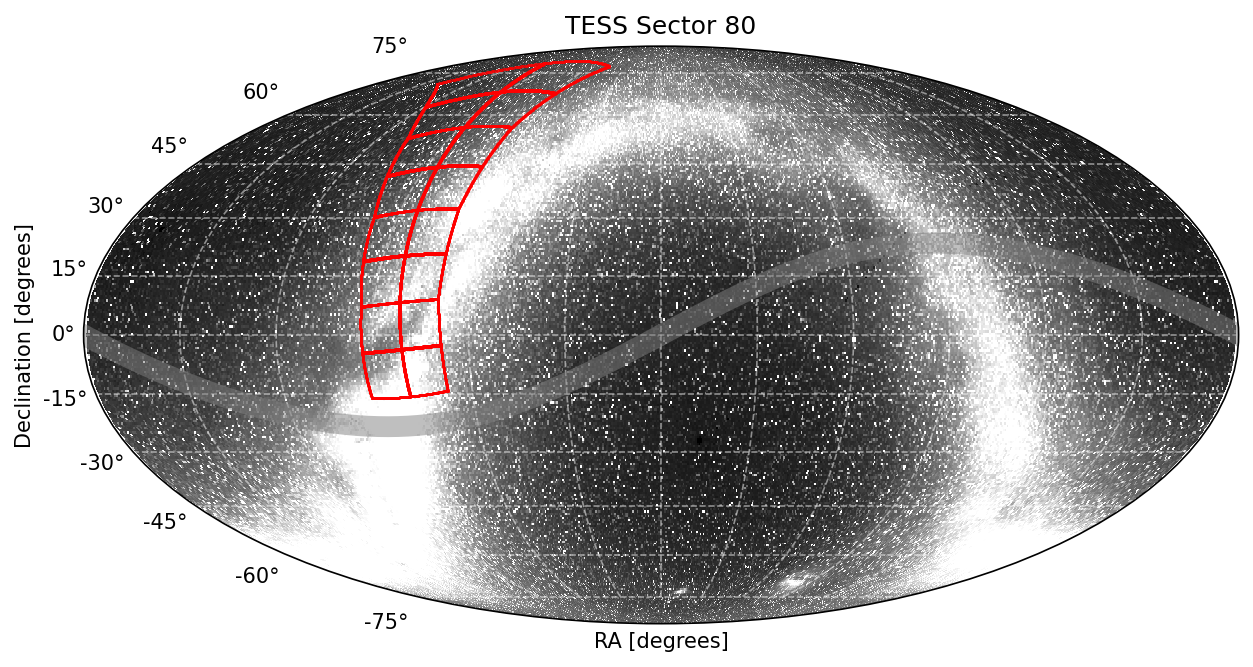

In [6]:
fig = plt.figure(figsize=(10, 5), facecolor=None)
ax = fig.add_subplot(111, projection="mollweide")
ax.grid(True, color='white', alpha=0.5, ls='--')

ax.pcolormesh(c_low.ra[2:-2, 2:-2].wrap_at(180*u.deg).rad, c_low.dec[2:-2, 2:-2].rad, zi[2:-2, 2:-2], vmin=0, vmax=1000, cmap='Greys_r')
s = np.argsort(ecliptic_plane.ra.wrap_at(180 * u.deg).rad)
ax.plot(ecliptic_plane.ra.wrap_at(180 * u.deg).rad[s], ecliptic_plane.dec.rad[s], color='grey', alpha=0.5, lw=10)

ax.set(facecolor=(0, 0, 0, 0), xlabel='RA [degrees]', ylabel='Declination [degrees]', xticklabels=[]);

def get_points(sector = 1):
    pointing = np.asarray(pointings[pointings['Sector'] == sector][['RA', "Dec", "Roll"]])[0]
    x, y = [], []
    for camera in np.arange(1, 5):
        for ccd in np.arange(1, 5):
            wcs = tesswcs.WCS.predict(*pointing, camera=camera, ccd=ccd)
            c = wcs.pixel_to_world(*footprint(npoints=100).T)
            x.append(c.ra.wrap_at(180*u.deg).deg)
            y.append(c.dec.deg)
    return np.hstack(x), np.hstack(y)

scatter = ax.scatter([], [], c='r', s=0.1, zorder=10)

def update(sector):
    scatter.set_offsets(np.deg2rad(np.vstack(get_points(sector=sector)).T))
    ax.set_title(f'TESS Sector {sector}')
    plt.savefig(f'tess_icrs_sector_{sector:03d}.png')
    

ani = FuncAnimation(fig, update, frames=np.arange(80, 85), repeat=False)

# Save the animation as a GIF
writer = PillowWriter(fps=1)
ani.save("tess_sectors_icrs_coordinates.gif", writer=writer)